Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable (0 or 1)

0 means that a female has non-diabetic and 1 means that a female is diabetes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
import random
import string
import sys

# sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

import pickle

import wandb

import warnings
warnings.filterwarnings('ignore')

# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
wandb.login()

In [3]:
df = pd.read_csv('diabetes.csv')

In [4]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
df.shape

(768, 9)

In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
for d in df.columns:
    print(d)
    print(df[d].value_counts())

Pregnancies
1     135
0     111
2     103
3      75
4      68
5      57
6      50
7      45
8      38
9      28
10     24
11     11
13     10
12      9
14      2
15      1
17      1
Name: Pregnancies, dtype: int64
Glucose
99     17
100    17
111    14
129    14
125    14
       ..
191     1
177     1
44      1
62      1
190     1
Name: Glucose, Length: 136, dtype: int64
BloodPressure
70     57
74     52
78     45
68     45
72     44
64     43
80     40
76     39
60     37
0      35
62     34
66     30
82     30
88     25
84     23
90     22
86     21
58     21
50     13
56     12
52     11
54     11
75      8
92      8
65      7
85      6
94      6
48      5
96      4
44      4
100     3
106     3
98      3
110     3
55      2
108     2
104     2
46      2
30      2
122     1
95      1
102     1
61      1
24      1
38      1
40      1
114     1
Name: BloodPressure, dtype: int64
SkinThickness
0     227
32     31
30     27
27     23
23     22
33     20
28     20
18     20
31     19
19   

In [9]:
df['Outcome'].value_counts() * 100 / len(df)

0    65.104167
1    34.895833
Name: Outcome, dtype: float64

In [10]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [11]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']] = \
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']].replace(0, np.NaN)

In [12]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

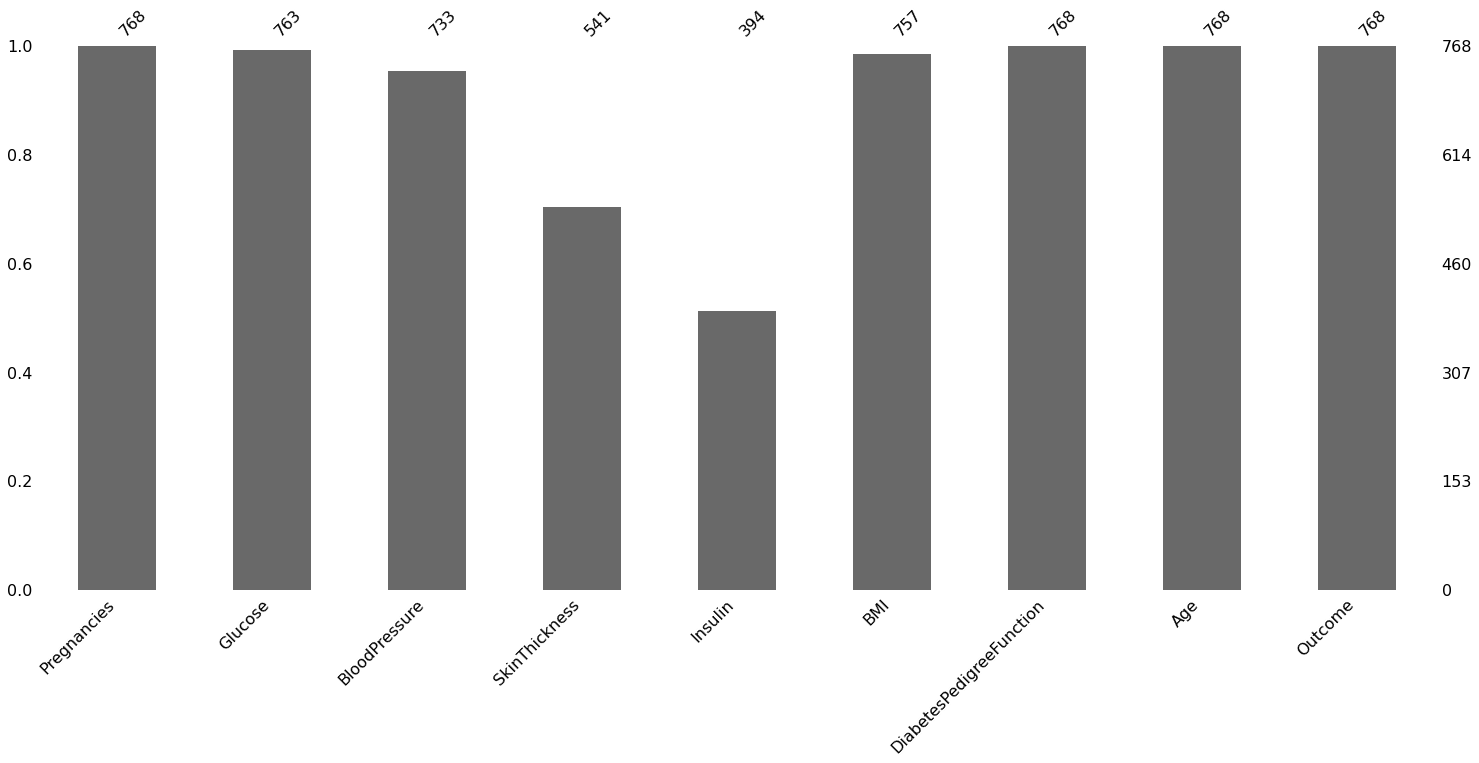

In [13]:
msno.bar(df);

In [14]:
imputer = KNNImputer(n_neighbors=2)
df_ = pd.DataFrame(imputer.fit_transform(df),columns=df.columns)

In [15]:
def translateBMI(bmi):
    if bmi <= 18.5:
        return 'Underweight'
    elif bmi > 18.5 and bmi <= 24.9:
        return 'Normal'
    elif bmi > 24.9 and bmi <= 29.9:
        return 'Overweight'
    elif bmi > 29.9 and bmi <= 34.9:
        return 'Obesity 1'
    elif bmi > 34.9 and bmi <= 39.9:
        return 'Obesity 2'
    elif bmi > 39.9:
        return 'Obesity 3'

In [16]:
df_['Fat'] = df_['BMI'].apply(translateBMI)

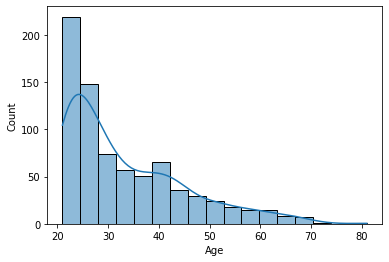

In [17]:
sns.histplot(data=df_['Age'], kde=True);

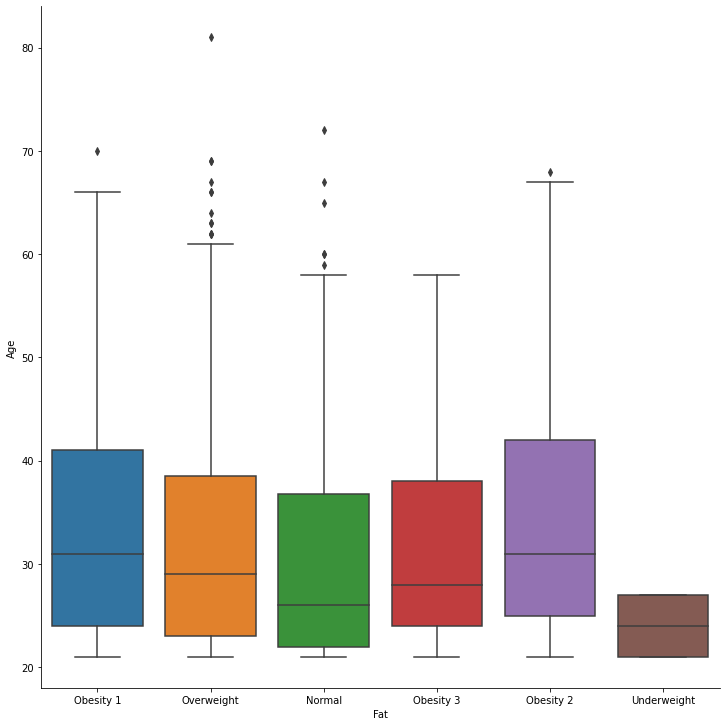

In [18]:
sns.catplot(x='Fat', y='Age', data=df_, kind='box', height=10);

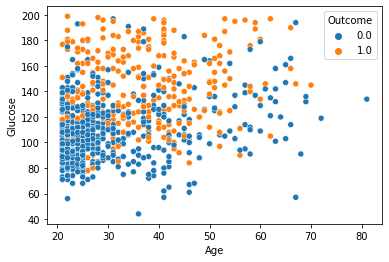

In [19]:
sns.scatterplot(x='Age', y='Glucose', hue='Outcome', data=df_);

In [20]:
df_.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Fat'],
      dtype='object')

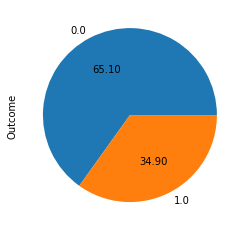

In [21]:
df_['Outcome'].value_counts().plot.pie(autopct='%.2f');

In [22]:
df_ = pd.get_dummies(df_, columns=['Fat'])
df_

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Fat_Normal,Fat_Obesity 1,Fat_Obesity 2,Fat_Obesity 3,Fat_Overweight,Fat_Underweight
0,6.0,148.0,72.0,35.0,113.0,33.6,0.627,50.0,1.0,0,1,0,0,0,0
1,1.0,85.0,66.0,29.0,88.5,26.6,0.351,31.0,0.0,0,0,0,0,1,0
2,8.0,183.0,64.0,24.0,227.5,23.3,0.672,32.0,1.0,1,0,0,0,0,0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0,0,0,0,0,1,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0.0,0,1,0,0,0,0
764,2.0,122.0,70.0,27.0,202.5,36.8,0.340,27.0,0.0,0,0,1,0,0,0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0.0,0,0,0,0,1,0
766,1.0,126.0,60.0,33.5,123.5,30.1,0.349,47.0,1.0,0,1,0,0,0,0


In [23]:
df_.columns = df_.columns.str.replace(' ', '_').str.lower()

In [24]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pregnancies               768 non-null    float64
 1   glucose                   768 non-null    float64
 2   bloodpressure             768 non-null    float64
 3   skinthickness             768 non-null    float64
 4   insulin                   768 non-null    float64
 5   bmi                       768 non-null    float64
 6   diabetespedigreefunction  768 non-null    float64
 7   age                       768 non-null    float64
 8   outcome                   768 non-null    float64
 9   fat_normal                768 non-null    uint8  
 10  fat_obesity_1             768 non-null    uint8  
 11  fat_obesity_2             768 non-null    uint8  
 12  fat_obesity_3             768 non-null    uint8  
 13  fat_overweight            768 non-null    uint8  
 14  fat_underw

In [25]:
X = df_.drop(['outcome'], axis=1)
y = df_['outcome']

In [26]:
y.value_counts()

0.0    500
1.0    268
Name: outcome, dtype: int64

## Model

In [27]:
rus = RandomUnderSampler(sampling_strategy=1) 
X_res, y_res = rus.fit_resample(X, y)

In [28]:
y_res.value_counts()

0.0    268
1.0    268
Name: outcome, dtype: int64

In [29]:
ros = RandomOverSampler(sampling_strategy='not majority')
X_res2, y_res2 = ros.fit_resample(X, y)

In [30]:
y_res2.value_counts()

1.0    500
0.0    500
Name: outcome, dtype: int64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=43)

LR: 0.747508 (0.041077)
KNN: 0.726800 (0.040918)
DT: 0.675138 (0.059687)
RF: 0.773367 (0.060655)
SVM: 0.481229 (0.047043)
GB: 0.771041 (0.053855)
LGBM: 0.750055 (0.056784)


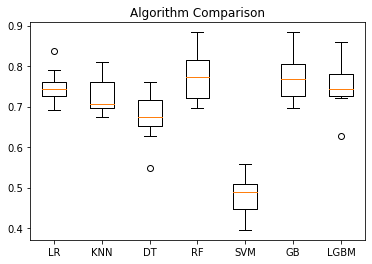

In [32]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('GB', GradientBoostingClassifier()))
models.append(('LGBM', LGBMClassifier()))

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

#### --- Ramdom Name

In [33]:
CONSONANTS = ''.join(string.ascii_lowercase)
NUMBERS = ''.join(string.digits)

def generate_word(length):
    word = ""
    for i in range(length):
        word += random.choice(CONSONANTS)
        word += random.choice(NUMBERS)
    return word

### Gradient Boosting Model - Tuning

In [ ]:
run = wandb.init(project='ml-diabetesexample', name='GB')

In [35]:
clf = GradientBoostingClassifier(random_state=43)

clf_params = {'learning_rate': [0.01, 0.1, 0.2, 1],
             'min_samples_split': np.linspace(0.1, 0.5, 10),
             'max_depth': [3, 5, 8],
             'subsample': [0.5, 0.9, 1.0],
             'n_estimators': [100, 300, 500, 700, 900]
            }

clf_cv  = GridSearchCV(clf, clf_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)
clf_cv.best_params_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


{'learning_rate': 0.1}

In [36]:
clf_tuning = GradientBoostingClassifier(**clf_cv.best_params_).fit(X_train, y_train)

In [37]:
clf_tuning = clf_tuning.fit(X_train, y_train)

In [38]:
y_pred = clf_tuning.predict(X_test)

In [39]:
y_probas = clf_tuning.predict_proba(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.72      0.73        53
         1.0       0.74      0.76      0.75        55

    accuracy                           0.74       108
   macro avg       0.74      0.74      0.74       108
weighted avg       0.74      0.74      0.74       108



In [41]:
cross_val_score(clf_tuning, X_train, y_train, cv=10).mean()

0.7920819490586932

In [42]:
labels = np.array([0, 1])
#labels = np.array(['positive', 'negative'])
labels

array([0, 1])

In [43]:
feature_names = np.array(X.columns)
feature_names

array(['pregnancies', 'glucose', 'bloodpressure', 'skinthickness',
       'insulin', 'bmi', 'diabetespedigreefunction', 'age', 'fat_normal',
       'fat_obesity_1', 'fat_obesity_2', 'fat_obesity_3',
       'fat_overweight', 'fat_underweight'], dtype=object)

In [44]:
modelname = generate_word(5) + '.pkl'
pickle.dump(clf_tuning, open(os.path.join(wandb.run.dir, modelname), 'wb'))

filename = os.path.join(wandb.run.dir, modelname)

In [45]:
wandb.config.update(clf_cv.best_params_)
wandb.config.filemodel = wandb.run.dir + '/' + modelname

In [ ]:
wandb.sklearn.plot_classifier(clf_tuning, 
                              X_train, X_test, 
                              y_train, y_test, 
                              y_pred, y_probas, 
                              labels, 
                              is_binary=True, 
                              model_name='GradientBoosting',
                              feature_names=feature_names)

wandb.finish()

In [ ]:
filename

In [49]:
# inference model 
load_model = pickle.load(open(filename, 'rb'))
load_model.predict([[7, 181, 84, 21, 192, 35.9, 0.599, 42, 0, 0, 1, 0, 0, 0]])

array([1.])

### Random Forest Model - Tuning

In [ ]:
run = wandb.init(project='ml-diabetesexample', name='RF')

In [51]:
clf = RandomForestClassifier(random_state=43)

clf_params = {'n_estimators': [100, 300, 500, 1000], 
             'max_features': [3, 5, 7], 
             'min_samples_split': [2, 5, 10, 30],
             'max_depth': [3, 5, 8, None]
            }

clf_cv  = GridSearchCV(clf, clf_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)
clf_cv.best_params_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


{'n_estimators': 100}

In [52]:
clf_tuning = RandomForestClassifier(**clf_cv.best_params_)

In [53]:
clf_tuning = clf_tuning.fit(X_train, y_train)

In [54]:
y_pred = clf_tuning.predict(X_test)

In [55]:
y_probas = clf_tuning.predict_proba(X_test)

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.60      0.66        53
         1.0       0.67      0.78      0.72        55

    accuracy                           0.69       108
   macro avg       0.70      0.69      0.69       108
weighted avg       0.70      0.69      0.69       108



In [57]:
cross_val_score(clf_tuning, X_train, y_train, cv=10).mean()

0.7898117386489479

In [ ]:
labels = np.array([0, 1])
#labels = np.array(['positive', 'negative'])
labels

In [58]:
feature_names = np.array(X.columns)
feature_names

array(['pregnancies', 'glucose', 'bloodpressure', 'skinthickness',
       'insulin', 'bmi', 'diabetespedigreefunction', 'age', 'fat_normal',
       'fat_obesity_1', 'fat_obesity_2', 'fat_obesity_3',
       'fat_overweight', 'fat_underweight'], dtype=object)

In [59]:
modelname = generate_word(5) + '.pkl'
pickle.dump(clf_tuning, open(os.path.join(wandb.run.dir, modelname), 'wb'))

filename = os.path.join(wandb.run.dir, modelname)

In [60]:
wandb.config.update(clf_cv.best_params_)
wandb.config.filemodel = wandb.run.dir + '/' + modelname

In [ ]:
wandb.sklearn.plot_classifier(clf_tuning, 
                              X_train, X_test, 
                              y_train, y_test, 
                              y_pred, y_probas, 
                              labels, 
                              is_binary=True, 
                              model_name='RandomForest',
                              feature_names=feature_names)

wandb.finish()

In [ ]:
filename

In [62]:
# inference model 
load_model = pickle.load(open(filename, 'rb'))
load_model.predict([[7, 181, 84, 21, 192, 35.9, 0.599, 42, 0, 0, 1, 0, 0, 0]])

array([1.])

### LGBM Model - Tuning

In [ ]:
run = wandb.init(project='ml-diabetesexample', name='LGBM')

In [64]:
clf = LGBMClassifier(random_state=43)

clf_params = {'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.5],
               'n_estimators': [100, 500, 1000, 1500],
               'max_depth': [3,5,8]
              }

clf_cv = GridSearchCV(clf, clf_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)
clf_cv.best_params_

Fitting 10 folds for each of 5 candidates, totalling 50 fits


{'learning_rate': 0.01}

In [65]:
clf_tuning = LGBMClassifier(**clf_cv.best_params_).fit(X_train, y_train)

In [66]:
clf_tuning = clf_tuning.fit(X_train, y_train)

In [67]:
y_pred = clf_tuning.predict(X_test)

In [68]:
y_probas = clf_tuning.predict_proba(X_test)

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.64      0.70        53
         1.0       0.70      0.82      0.76        55

    accuracy                           0.73       108
   macro avg       0.74      0.73      0.73       108
weighted avg       0.74      0.73      0.73       108



In [70]:
cross_val_score(clf_tuning, X_train, y_train, cv=10).mean()

0.7828349944629014

In [71]:
labels = np.array([0, 1])
#labels = np.array(['positive', 'negative'])
labels

array([0, 1])

In [72]:
feature_names = np.array(X.columns)
feature_names

array(['pregnancies', 'glucose', 'bloodpressure', 'skinthickness',
       'insulin', 'bmi', 'diabetespedigreefunction', 'age', 'fat_normal',
       'fat_obesity_1', 'fat_obesity_2', 'fat_obesity_3',
       'fat_overweight', 'fat_underweight'], dtype=object)

In [73]:
modelname = generate_word(5) + '.pkl'
pickle.dump(clf_tuning, open(os.path.join(wandb.run.dir, modelname), 'wb'))

filename = os.path.join(wandb.run.dir, modelname)

In [74]:
wandb.config.update(clf_cv.best_params_)
wandb.config.filemodel = wandb.run.dir + '/' + modelname

In [ ]:
wandb.sklearn.plot_classifier(clf_tuning, 
                              X_train, X_test, 
                              y_train, y_test, 
                              y_pred, y_probas, 
                              labels, 
                              is_binary=True, 
                              model_name='LightGBM',
                              feature_names=feature_names)

wandb.finish()

In [ ]:
filename

In [77]:
# inference model 
load_model = pickle.load(open(filename, 'rb'))
load_model.predict([[7, 181, 84, 21, 192, 35.9, 0.599, 42, 0, 0, 1, 0, 0, 0]])

array([1.])

### Final Comparison Models

GB: 0.775748 (0.047692)
RF: 0.780399 (0.056117)
LGBM: 0.735991 (0.062398)


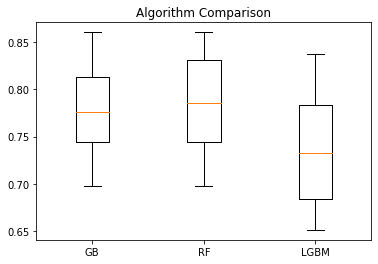

In [78]:
models = []
models.append(('GB', GradientBoostingClassifier(random_state=43, max_depth=5, min_samples_split=0.1, n_estimators=100, subsample=0.9)))
models.append(('RF', RandomForestClassifier(random_state=43, max_features=7, min_samples_split=5, n_estimators=500)))
models.append(('LGBM', LGBMClassifier(random_state=43, learning_rate=0.05, max_depth=8, n_estimators=1500)))

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()